In [3]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.4.0 


In [2]:
import pydicom
import os


In [6]:
PathDicom = "/mnt/storage/Evidences/LEAL/series1/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [9]:
image = pydicom.read_file(lstFilesDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(image.Rows), int(image.Columns), len(lstFilesDCM))
ConstPixelSpacing = (float(image.PixelSpacing[0]), float(image.PixelSpacing[1]), float(image.SliceThickness))
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

ArrayDicom = np.zeros(ConstPixelDims, dtype=image.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

In [14]:
def open_image(image_dicom_short_field):#lets open this image like a #!@#!@#! on prom day
    min_image_value = np.amin(image_dicom_short_field)
    max_image_value = np.amax(image_dicom_short_field)
    min_max_range = max_image_value - min_image_value
    windowed_image = image_dicom_short_field.copy()

    for x in np.nditer(windowed_image, op_flags=['readwrite']):
        x[...] = 255*x/(min_max_range)
    return windowed_image



array([[1052, 1053, 1055, ..., 1048, 1050, 1051],
       [1050, 1052, 1054, ..., 1048, 1050, 1051],
       [1049, 1051, 1053, ..., 1048, 1049, 1050],
       ...,
       [1040, 1037, 1036, ..., 1037, 1040, 1043],
       [1040, 1037, 1035, ..., 1034, 1037, 1040],
       [1041, 1037, 1034, ..., 1032, 1035, 1038]], dtype=uint16)

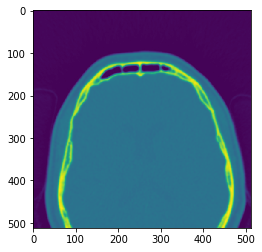

In [77]:
#plt.pcolormesh(x, y, windowed_image[:,:])
windowed_image = open_image(ArrayDicom[:,:,91])
plt.imshow(windowed_image, interpolation='nearest')
plt.show()

In [20]:

image = cv2.cvtColor(windowed_image.astype(np.uint8),cv2.COLOR_GRAY2BGR)
piramid_image = shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
true_image = cv2.cvtColor(piramid_image,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(true_image,0,255,cv2.THRESH_BINARY +cv2.THRESH_OTSU)

In [18]:

#plt.imshow(thresh, interpolation='nearest')
#plt.show()

In [22]:
## noise removal
#kernel = np.ones((3,3),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
## sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
## Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
# Finding unknown region
#sure_fg = np.uint8(sure_fg)
#unknown = cv2.subtract(sure_bg,sure_fg)

In [58]:
import math
def pinte_bolinha(centerx, centery,image,radius,value):
    for y in range (centery-radius, centery+radius):
        for x in range(centerx-radius, centerx +radius):
            sqx = centerx -x;
            sqx = sqx*sqx;
            sqy = centery -y;
            sqy = sqy*sqy;
            if math.sqrt(sqy+sqx) < radius:
                image[y,x]=value
                


In [30]:
#sure_fg.fill(0)
#for inha in range(254,256):
#    for joluna in range (254,256):
#        sure_fg[inha,joluna]=255
#pinte_bolinha(30,200,sure_fg,10,200)
#plt.imshow(sure_fg, interpolation='nearest')
#plt.show()

In [31]:
#teste = windowed_image.copy()
#pinte_bolinha(115,419,teste,8,200)
#plt.imshow(teste, interpolation='nearest')
#plt.show()

In [32]:
# Marker labelling
#ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
#markers = markers+1
# Now, mark the region of unknown with zero
#markers[unknown==255] = 0

#markers.fill(0)
#pinte_bolinha(105,199,markers,8,1)
#pinte_bolinha(115,419,markers,8,2)
#pinte_bolinha(86,99,markers,8,2)
#pinte_bolinha(305,199,markers,8,3)
#pinte_bolinha(305,419,markers,8,4)

In [65]:
def create_markers_field(image):
    mark = image.copy().astype(np.int32)
    mark.fill(0)
    return mark

def add_mark_to_field(marker_field, x, y, label):
    #marker_field[y,x] =label
    pinte_bolinha(x,y,marker_field, 3,label)
    
    
    

In [83]:
marker_field_on_start_image = create_markers_field(windowed_image)
add_mark_to_field(marker_field_on_start_image,10,19,1)
add_mark_to_field(marker_field_on_start_image,170,150,2)
add_mark_to_field(marker_field_on_start_image,255,255,3)

In [35]:
#plt.imshow(markers, interpolation='nearest')
#plt.show()
#markers

In [79]:
def update_markers_with_watershed(image,marker):
    colored_image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    
    res = cv2.watershed(colored_image,marker)
    colored_image[res ==1] = [255,0,0]
    colored_image[res ==2] = [0,255,0]
    colored_image[res ==3] = [0,0,255]
    plt.imshow(colored_image, interpolation='nearest')
    plt.show()
    return res

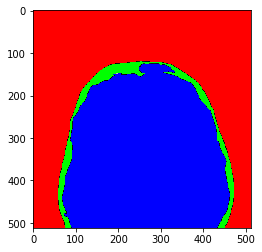

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [84]:

marker_field_on_start_image
update_markers_with_watershed(windowed_image.astype(np.uint8),marker_field_on_start_image)

#colored = cv2.cvtColor(true_image,cv2.COLOR_GRAY2BGR)
#markers = cv2.watershed(colored,markers)
#colored[markers == 1] = [255,0,0]
#colored[markers == 3] = [0,255,0]
#colored[markers == 4] = [0,0,255]

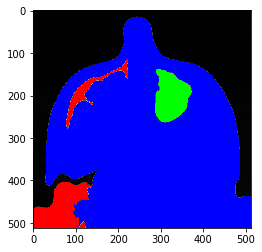

In [328]:
plt.imshow(colored, interpolation='nearest')
plt.show()

In [315]:
import mpld3

ImportError: No module named 'mpld3'